<a href="https://colab.research.google.com/github/bkricardo/eluvio/blob/main/eluvio_yuanpei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#load data from google drive
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)
%cd ./gdrive/My Drive/eluvio_hw

Mounted at /content/gdrive
/content/gdrive/My Drive/eluvio_hw


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1.Data Inspection

In [138]:
eluvio = pd.read_csv('Eluvio_DS_Challenge.csv',parse_dates=['date_created'])
eluvio.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [139]:
eluvio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   time_created  509236 non-null  int64         
 1   date_created  509236 non-null  datetime64[ns]
 2   up_votes      509236 non-null  int64         
 3   down_votes    509236 non-null  int64         
 4   title         509236 non-null  object        
 5   over_18       509236 non-null  bool          
 6   author        509236 non-null  object        
 7   category      509236 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(3), object(3)
memory usage: 27.7+ MB


In [140]:
#we are dropping the category, downs_votes columns since it only contain one feature.
print(eluvio.groupby('category')["category"].count())
print('--------------------')
print(eluvio.groupby('down_votes')["down_votes"].count())
print('----------------------')
print(eluvio.groupby('over_18')["down_votes"].count())

category
worldnews    509236
Name: category, dtype: int64
--------------------
down_votes
0    509236
Name: down_votes, dtype: int64
----------------------
over_18
False    508916
True        320
Name: down_votes, dtype: int64


We observe the category and down_votes column are all the same, so we are dropping them.

In [39]:
eluvio.drop(['time_created','down_votes','category'],axis=1,inplace=True)
eluvio.head()

,date_created,up_votes,title,over_18,author
0,2008-01-25,3,Scores killed in Pakistan clashes,False,polar
1,2008-01-25,2,Japan resumes refuelling mission,False,polar
2,2008-01-25,3,US presses Egypt on Gaza border,False,polar
3,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420
4,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans


To have better sense of how upvotes changes, we plot out a time-series upvotes counts.

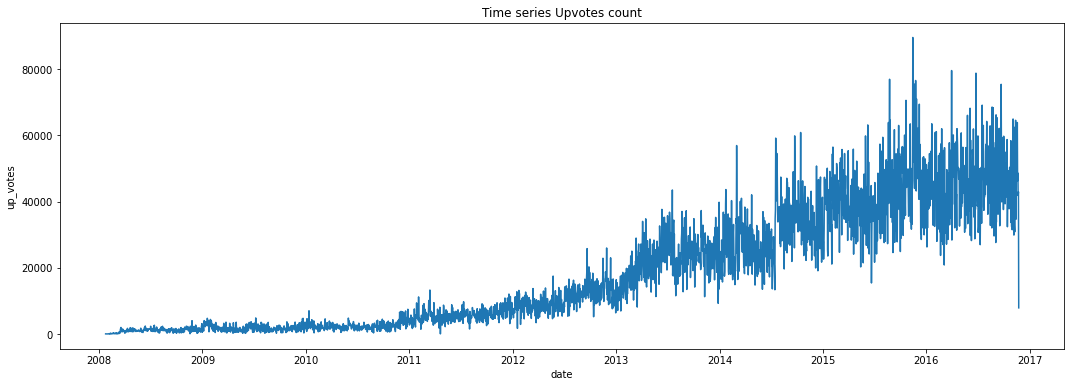

In [40]:
time_line = eluvio.groupby('date_created')['up_votes'].sum().index
vote_count = eluvio.groupby('date_created')['up_votes'].sum().values

fig,ax = plt.subplots(figsize=(18, 6))
plt.plot(time_line,vote_count)
plt.title('Time series Upvotes count')
plt.xlabel('date')
plt.ylabel('up_votes')
plt.show()

As time goes, the total upvotes in each year increase, the low total upvote for the year before 2014 might be due to the low community population. For the following task, we are only focusing on the post that happened after 2014 since we don't want the population size to affect our analysis.

In [141]:
after_14 = eluvio[eluvio['date_created']>='2014-01-01'].reset_index(drop=True)
print('number of posts after 2014: ',len(after_14))
after_14.head()

number of post after 2014:  268543


,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1388534470,2014-01-01,0,0,Syria: UN humanitarian chief decries ‘indiscri...,False,sarafabali123,worldnews
1,1388536125,2014-01-01,0,0,Homeless recruited for Japanese nuke cleanup |...,False,burtzev,worldnews
2,1388537120,2014-01-01,18,0,"Pollution Rising, Chinese Fear for Soil and Food",False,MoonMetropolis,worldnews
3,1388537216,2014-01-01,22,0,Chinese recycling tycoon says he wants to buy ...,False,MoonMetropolis,worldnews
4,1388538489,2014-01-01,0,0,"20th century Fox gave this guy $25,000. Very i...",False,pakiranian,worldnews


# 2.Analysis: entity - upvote relationship

In this analytic task, we want to inspect how the entity in the post title is distributed and related to the number of upvotes. 

2.1 Parse the post title using spacy

In [12]:
from collections import Counter
import re
import spacy
import pickle
gpu = spacy.prefer_gpu()
print('GPU:', gpu)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger'])

GPU: True


In [ ]:
#extrac title from the dataframe
titles_14 = after_14['title'].values
titles_14

array(['Syria: UN humanitarian chief decries ‘indiscriminate attacks’ in Aleppo',
       'Homeless recruited for Japanese nuke cleanup | TheHill',
       'Pollution Rising, Chinese Fear for Soil and Food', ...,
       'Professor receives Arab Researchers Award',
       'Nigel Farage attacks response to Trump ambassador tweet',
       'Palestinian wielding knife shot dead in West Bank: Israel police'],
      dtype=object)

In [ ]:
#parse the title using spacy, it take about 1.5 hours for parsing
title_nlp = [0] *len(after_14)
for i in range(len(title_14)):
    title_nlp[i] = nlp(title_14[i])

In [ ]:
#extract the entity label and text from the parsed title
#then saving them as pickle (because I'm finishing the task in separate days)
ent_list = [0] * len(after_14)
ent_name_list = [0] * len(after_14)

for i in range(len(title_nlp)):
    ent_temp = []
    ent_text_temp = []
    for ent in title_nlp[i].ents:
        ent_temp.append(ent.label_)
        ent_text_temp.append(ent.text)

    ent_list[i] = ent_temp
    ent_name_list[i] = ent_text_temp   

with open('ent_list.pickle', 'wb') as f:
    pickle.dump(ent_list, f)

with open('ent_name_list.pickle', 'wb') as f:
    pickle.dump(ent_name_list, f)

#counter the frequency of entity label
label_counter = Counter()
for title in title_nlp:
    for entity in title.ents:
        label_counter[entity.label_] +=1

with open('label_counter.pickle', 'wb') as f:
    pickle.dump(label_counter, f)

In [134]:
#load the saved pickle
ent_list = pd.read_pickle('ent_list.pickle')
ent_name_list = pd.read_pickle('ent_name_list.pickle')
label_counter = pd.read_pickle('label_counter.pickle')
print(ent_list[:5])
print(ent_name_list[:5])

[['GPE', 'ORG', 'GPE'], ['NORP'], ['NORP'], ['NORP', 'ORG'], ['DATE', 'PERSON', 'MONEY']]
[['Syria', 'UN', 'Aleppo'], ['Japanese'], ['Chinese'], ['Chinese', 'New York Times'], ['20th century', 'Fox', '25,000']]


Here are some explanation for entity labels in Spacy, This can be found using `spacy.explain("XXX")`

**GPE**: Countries, cities, states

**NORP**: Nationalities or religious or political groups

**ORG**: Companies, agencies, institutions, etc.

After getting the entity from spacy, we can check the frequency of the entity that appears in the post. 

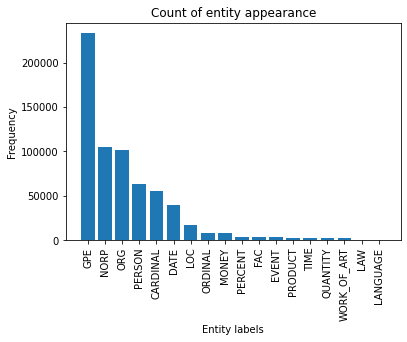

1st entity label propotion:  0.357
2nd entity label propotion:  0.1614
3rd entity label propotion:  0.1553


In [155]:
freq_count_plot(_,counter=label_counter) #Code of this helper function can be found at the bottom of the notebook.

We can see `GPE`, `NORP` and `ORG` are the more frequent entity label appear in the post, To dive in more, let's print out the top 10 most frequently occurred entities with label `GPE`, `NORP` and `ORG`.

In [137]:
top_10_count(ent_list,ent_name_list) #Code of this helper function can be found at the bottom of the notebook.

ORG top 10
EU             :   5174
UN             :   4269
ISIS           :   3787
Islamic State  :   1804
Hamas          :   1629
NATO           :   1470
Taliban        :   1377
U.N.           :   1266
Google         :    729
NSA            :    720
-------------------
GPE top 10
Russia         :  12848
China          :  12646
US             :  11895
Syria          :   9654
Ukraine        :   8942
U.S.           :   8565
Israel         :   6863
Iran           :   6320
UK             :   5768
Turkey         :   5758
-------------------
NORP top 10
Russian        :   7313
Syrian         :   4448
Israeli        :   4174
Chinese        :   3972
Islamic        :   3313
French         :   3157
Turkish        :   2847
German         :   2842
British        :   2704
Palestinian    :   2558


From the list, We can see Russia and China shows up the most in GPE, and Russian also appears most frequently in NORP. For organization (ORG), The top appearance is EU and UN, while we also see some terrorist appears at the top, such as ISIS, Islamic State, Taliban.

2.2 **Focus on the top 20% upvotes post**

From the intuition of the 80/20 rule(Pareto principle), roughly 80% of consequences come from 20% of the causes. We want to see how entity appears in the top 20% of most # of upvotes post.

In [147]:
after_14['entity_label'] = ent_list
after_14['entity_text'] = ent_name_list
after_14.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,entity_label,entity_text
0,1388534470,2014-01-01,0,0,Syria: UN humanitarian chief decries ‘indiscri...,False,sarafabali123,worldnews,"[GPE, ORG, GPE]","[Syria, UN, Aleppo]"
1,1388536125,2014-01-01,0,0,Homeless recruited for Japanese nuke cleanup |...,False,burtzev,worldnews,[NORP],[Japanese]
2,1388537120,2014-01-01,18,0,"Pollution Rising, Chinese Fear for Soil and Food",False,MoonMetropolis,worldnews,[NORP],[Chinese]
3,1388537216,2014-01-01,22,0,Chinese recycling tycoon says he wants to buy ...,False,MoonMetropolis,worldnews,"[NORP, ORG]","[Chinese, New York Times]"
4,1388538489,2014-01-01,0,0,"20th century Fox gave this guy $25,000. Very i...",False,pakiranian,worldnews,"[DATE, PERSON, MONEY]","[20th century, Fox, 25,000]"


In [60]:
after_14.describe()

,up_votes
count,268543.000000
mean,153.346202
std,686.153567
min,0.000000
25%,2.000000
50%,5.000000
75%,18.000000
max,21253.000000


In [156]:
#the 75% percentile is 18, we will slice the data from 20 for simplicity
top_votes = after_14[after_14['up_votes']> 20]
print("the # of top 20% upvote post: ",len(after_14[after_14['up_votes']> 20]))

the # of top 20% upvote post:  63258


Then we plot the frequency count and top entities list as before

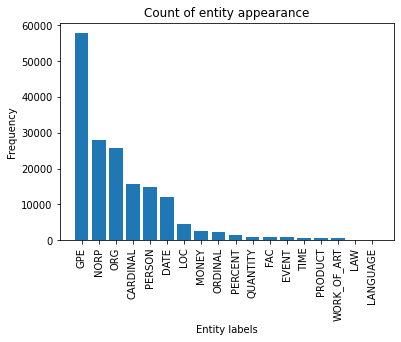

1st entity label propotion:  0.3395
2nd entity label propotion:  0.1642
3rd entity label propotion:  0.1513


In [157]:
top_votes_ent = top_votes['entity_label'].values
top_votes_name = top_votes['entity_text'].values
freq_count_plot(top_votes_ent)

The top 20% of most upvotes posts preserve a simliar pattern of distribution as the total post.

In [158]:
top_10_count(top_votes_ent,top_votes_name)

ORG top 10
ISIS           :   1225
EU             :   1155
UN             :    978
Hamas          :    497
Islamic State  :    436
NATO           :    394
NSA            :    371
Taliban        :    261
U.N.           :    247
CIA            :    244
-------------------
GPE top 10
Russia         :   3444
US             :   3106
China          :   2816
Ukraine        :   2261
U.S.           :   2146
Syria          :   1820
Israel         :   1689
UK             :   1550
Turkey         :   1499
India          :   1362
-------------------
NORP top 10
Russian        :   2118
Chinese        :   1026
Israeli        :    959
German         :    927
Islamic        :    923
Syrian         :    909
French         :    799
Turkish        :    794
British        :    765
Australian     :    636


In the top 20% upvote posts, We can see the ISIS in `ORG` has surpassed the EU and UN in the total post. Russia and Russia are still the most population entity that posts like to mention in `GPE` and `NORP`.

2.3 **From the most popular author perspective**

Another dimension we could look into is how an entity appears in the most popular author post.

We are using the top 10 author's posts in the following task. 

In [159]:
#difference in author
print(after_14.groupby('author')['up_votes'].sum().nlargest(10))

author
maxwellhill        1238249
anutensil          1025796
Libertatea          625081
Wagamaga            580121
DoremusJessup       559515
NinjaDiscoJesus     462750
madazzahatter       418642
madam1              340291
kulkke              296547
pnewell             276325
Name: up_votes, dtype: int64


In [160]:
author_lst = list(after_14.groupby('author')['up_votes'].sum().nlargest(10).index)
author_df = after_14[after_14['author'].isin(author_lst)]

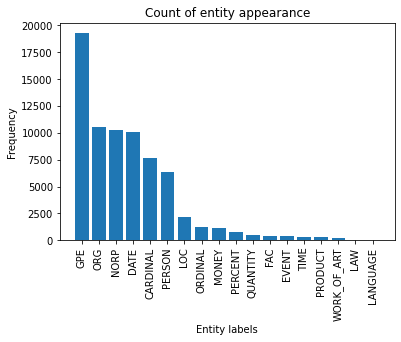

1st entity label propotion:  0.2683
2nd entity label propotion:  0.1471
3rd entity label propotion:  0.1427


In [161]:
author_ent = author_df['entity_label'].values
author_name = author_df['entity_text'].values
freq_count_plot(author_ent)

There is a larger decrease in proportion of `GPE` compare with `ORG` and `NORP` in total posts.

In [125]:
top_10_count(author_ent,author_name)

ORG top 10
EU             :    186
UN             :    137
NSA            :    106
Islamic State  :     64
U.N.           :     44
CIA            :     41
Islam          :     38
Amazon         :     37
Taliban        :     36
Google         :     33
-------------------
GPE top 10
US             :    370
China          :    314
UK             :    272
U.S.           :    249
Russia         :    240
Japan          :    212
Germany        :    188
Syria          :    167
Australia      :    162
Turkey         :    157
-------------------
NORP top 10
German         :    189
Russian        :    165
French         :    144
Islamic        :    129
British        :    126
Chinese        :    125
Turkish        :    101
Japanese       :     96
Syrian         :     86
European       :     73


For `ORG`, although EU, UN, and the terrorist group are still on the list, we can see some giant tech are also appear on the list, like Google, Amazon.
Then, in `GPE`, the US and U.S. have become the most appeared entity. This might because most of the popular authors are focusing on US-related news.

In the end, surprisingly, German appears the most in the `NORP` instead of Russian in other dimensions of entity counts. We might want to look into it.



## 3.Conclusion

From this entity appearance analytic task, we see  Russia is the most frequent topic in whether high upvote posts or normal posts. For organizations, the EU, the UN, And Terrorist groups like ISIS are the most frequent topic.

**For further work such as predictive model.**

We can use a pre-trained model like BERT to predict the popularity of a post base on its title. We can transform the number of upvotes to a certain label like ['unnoticed', 'popular', 'very popular'] to make it a classification task. On the other hand, Since BERT is a pre-train model, fine-tuning won't cost much computing power. 

## 4.Helper function

In [153]:
def freq_count_plot(ent_label,counter = None): #a helper function to plot the frequency
    if counter == None:
        ent_counter = Counter()
        for lst in ent_label:
            for item in lst:
                ent_counter[item] +=1
    else:
        ent_counter = counter

    sorted_label = sorted(ent_counter.items(),reverse = True, key = lambda x: x[1])
    labels = [label for label,count in sorted_label]
    counts = [count for label,count in sorted_label]
    plt.bar(range(len(labels)),counts)
    plt.xticks(range(len(labels)),labels,rotation=90)
    plt.title('Count of entity appearance')
    plt.xlabel('Entity labels')
    plt.ylabel('Frequency')
    plt.show()

    print('1st entity label propotion: ',round(counts[0]/sum(counts),4))
    print('2nd entity label propotion: ',round(counts[1]/sum(counts),4))
    print('3rd entity label propotion: ',round(counts[2]/sum(counts),4))

In [117]:
def top_10_count(ent_label,ent_text):
    org_entity = dict()
    gpe_entity = dict()
    norp_entity = dict()

    for i in range(len(ent_label)):
        curr_entities = ent_label[i]
        curr_text = ent_text[i]
        for j in range(len(curr_entities)):

            if curr_entities[j] == 'GPE':
                if curr_text[j] not in gpe_entity:
                    gpe_entity[curr_text[j]] = 0
                else:
                    gpe_entity[curr_text[j]] += 1
            
            if curr_entities[j] == 'NORP':
                if curr_text[j] not in norp_entity:
                    norp_entity[curr_text[j]] = 0
                else:
                    norp_entity[curr_text[j]] += 1

            if curr_entities[j] == 'ORG':
                if curr_text[j] not in org_entity:
                    org_entity[curr_text[j]] = 0
                else:
                    org_entity[curr_text[j]] += 1

    sorted_org = sorted(org_entity.items(),reverse = True, key = lambda x: x[1])
    sorted_gpe = sorted(gpe_entity.items(),reverse = True, key = lambda x: x[1])
    sorted_norp = sorted(norp_entity.items(),reverse = True, key = lambda x: x[1])

    print('ORG top 10')
    for ent,freq in sorted_org[:10]:
        print("{:14} : {:6}".format(ent,freq))
        
    print('-------------------')
    print('GPE top 10')
    for ent,freq in sorted_gpe[:10]:
        print("{:14} : {:6}".format(ent,freq))

    print('-------------------')
    print('NORP top 10')
    for ent,freq in sorted_norp[:10]:
        print("{:14} : {:6}".format(ent,freq))